# Check emission pairs to see which are missing in construction

In [162]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
sys.path.append("..")

from src.examples.example_setups import setup_stat_scm
from src.utils.sem_utils.emissions import get_emissions_input_output_pairs
from src.utils.sequential_causal_functions import sequentially_sample_model
from src.utils.sem_utils.emissions import fit_sem_emit_fncs
from numpy.random import seed


seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


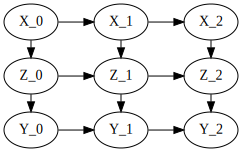

In [182]:
T = 3 # In this example, as in the paper, we consider three time-slices
init_sem, sem, dag_view, dag, exploration_sets, intervention_domain, true_objective_values  = setup_stat_scm(T=3)
# This is just a snapshot of the DAG at hand
dag_view

In [183]:
dag.add_edge("Z_0","X_0")
dag.add_edge("Z_1","X_1")
dag.add_edge("Z_2","X_2")

dag.remove_edge("X_0","Z_0")
dag.remove_edge("X_1","Z_1")
dag.remove_edge("X_2","Z_2")

In [184]:
node_children, node_parents, emission_pairs = get_emissions_input_output_pairs(T, dag)
emission_pairs

{('Z_0',): ('Y_0', 'X_0'), ('Z_1',): ('Y_1', 'X_1'), ('Z_2',): ('Y_2', 'X_2')}

In [187]:
node_parents

{'X_0': ('Z_0',),
 'Z_0': (),
 'Y_0': ('Z_0',),
 'X_1': ('X_0', 'Z_1'),
 'Z_1': ('Z_0',),
 'Y_1': ('Y_0', 'Z_1'),
 'X_2': ('X_1', 'Z_2'),
 'Z_2': ('Z_1',),
 'Y_2': ('Y_1', 'Z_2')}

In [169]:
# Number of independent samples (samples here are the time-series on the horizontal) per time-index
D_O = sequentially_sample_model(init_sem,
                                sem,
                                total_timesteps=T,
                                sample_count=5, # How many samples we take per node in each time-slice
                                epsilon=None) # If we employ a noise model or not

D_O

{'X': array([[-0.18718385,  1.34559536,  2.81495413],
        [ 1.23029068,  2.43267053,  2.04534371],
        [-0.4380743 , -1.69086966, -0.91337931],
        [-0.02818223,  0.40014964,  0.46666686],
        [-1.7262826 , -1.54885646, -1.9506374 ]]),
 'Z': array([[ 1.36079639e+00,  1.99934354e+00,  1.17146526e+00],
        [-1.00951244e-02, -9.70846048e-01, -2.26152826e+00],
        [-6.41777977e-02,  5.14727779e+00,  6.74454325e+00],
        [ 1.33105500e+00,  1.36695265e+00,  1.63130045e+00],
        [ 3.98952593e+00,  9.15839370e+00,  1.52842644e+01]]),
 'Y': array([[-2.7065599 , -4.374889  , -4.77284705],
        [-1.70682603, -0.24118898, -2.50766016],
        [ 0.38162977, -0.48095265, -1.4798827 ],
        [-1.37062265, -2.46167665, -4.25696293],
        [-1.42874866, -2.29698541, -3.54527713]])}

In [170]:
fncs = fit_sem_emit_fncs(D_O, emission_pairs)
fncs

{0: {('Z_0',): <GPy.models.gp_regression.GPRegression at 0x7ff55896fb10>,
  ('X_0',): <GPy.models.gp_regression.GPRegression at 0x7ff508cfd3d0>},
 1: {('X_1',): <GPy.models.gp_regression.GPRegression at 0x7ff508cdc6d0>,
  ('Z_1',): <GPy.models.gp_regression.GPRegression at 0x7ff558988090>},
 2: {('X_2',): <GPy.models.gp_regression.GPRegression at 0x7ff55896ff10>,
  ('Z_2',): <GPy.models.gp_regression.GPRegression at 0x7ff558988210>}}

In [185]:
fncs = fit_sem_emit_fncs(D_O, emission_pairs)
fncs

{0: {('Z_0',): {'Y': <GPy.models.gp_regression.GPRegression at 0x7ff5394c3a90>,
   'X': <GPy.models.gp_regression.GPRegression at 0x7ff5394ac3d0>}},
 1: {('Z_1',): {'Y': <GPy.models.gp_regression.GPRegression at 0x7ff558999290>,
   'X': <GPy.models.gp_regression.GPRegression at 0x7ff5394c66d0>}},
 2: {('Z_2',): {'Y': <GPy.models.gp_regression.GPRegression at 0x7ff5394afb90>,
   'X': <GPy.models.gp_regression.GPRegression at 0x7ff518bd8490>}}}

In [186]:
fncs[0]

{('Z_0',): {'Y': <GPy.models.gp_regression.GPRegression at 0x7ff5394c3a90>,
  'X': <GPy.models.gp_regression.GPRegression at 0x7ff5394ac3d0>}}

In [178]:
from networkx import topological_sort
from src.utils.dag_utils.graph_functions import get_subgraph, get_summary_graph_node_parents

In [177]:
gg = get_subgraph(0,['X','Z','Y'],dag)
list(v.split("_")[0] for v in topological_sort(gg))

['Z', 'Y', 'X']

In [227]:
a,b = get_summary_graph_node_parents(['X','Z','Y'], dag)
# a['X'] = ('B',)
a

{'Z': (), 'Y': ('Z',), 'X': ('Z',)}

In [234]:
[k for (k,v) in Counter(a.values()).items() if v > 1 ]
# dict(Counter(a.values()))

[('Z',)]

In [239]:
[k for k,v in a.items() if v == ('Z',)]

['Y', 'X']